## 🔑 OpenAI API Key

In [12]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_KEY = os.getenv("OPENAI_API_KEY")

## 📚 Imports

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
from IPython.display import display

import traceback
import re # To clean the LLM Output

## 📥 Load datasets


In [14]:
yt_df = pd.read_csv("../data/youtube_data.csv")
rd_df = pd.read_csv("../data/reddit_data.csv")

## 🧹 Previews


In [15]:
print("🎥 YouTube data shape:", yt_df.shape)
print("📕 Reddit data shape:", rd_df.shape)

🎥 YouTube data shape: (74, 6)
📕 Reddit data shape: (194, 13)


## 🎯 Aggregated Sentiment Analysis


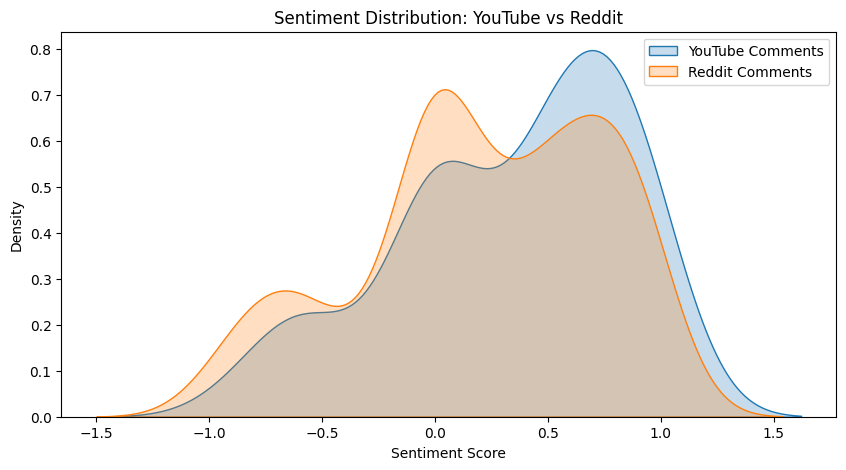

In [16]:
# Create plot
plt.figure(figsize=(10, 5))
sns.kdeplot(yt_df['comment_sentiment'], label='YouTube Comments', fill=True)
sns.kdeplot(rd_df['comment_sentiment'], label='Reddit Comments', fill=True)
plt.title('Sentiment Distribution: YouTube vs Reddit')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()

# ✅ Save BEFORE showing (Otherwise, a blank image will be saved)
plt.savefig("../data/sentiment_distribution.png", bbox_inches="tight")

# Then show (for notebook preview)
plt.show()
plt.close()


## 📊 Average Sentiment Comparison


In [17]:
avg_sentiments = pd.DataFrame({
    'Platform': ['YouTube', 'Reddit'],
    'Avg Comment Sentiment': [yt_df['comment_sentiment'].mean(), rd_df['comment_sentiment'].mean()]
})
display(avg_sentiments)

,Platform,Avg Comment Sentiment
0,YouTube,0.338159
1,Reddit,0.209731


## 🧠 Create grouped summaries for LLM


In [18]:
# Instantiating OpenAI
client = OpenAI(api_key=OPENAI_KEY)

In [19]:
topics = yt_df['video_title'].unique()
final_outputs = []

for topic in topics:
    yt_comments = yt_df[yt_df['video_title'] == topic]['comment'].dropna().tolist()
    reddit_rows = rd_df[rd_df['youtube_title'] == topic]
    reddit_post = reddit_rows['reddit_post_title'].unique()[0] if not reddit_rows.empty else "No Reddit post found"
    reddit_comments = reddit_rows['comment'].dropna().tolist()

    if not yt_comments and not reddit_comments:
        continue

    # ✅ Cleaned, limited comments for brevity
    yt_sample = "\n- ".join(yt_comments[:3])
    rd_sample = "\n- ".join(reddit_comments[:3])

    # ✅ Full prompt passed to model
    user_prompt = f"""
Video Title: {topic}
Reddit Post Title: {reddit_post}

🟦 YouTube Comments:
- {yt_sample}

🟥 Reddit Comments:
- {rd_sample}
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "You are a social media analyst. Analyze public perception around this topic using the comments from YouTube and Reddit. Provide a concise summary and highlight any sentiment trends or contrasting opinions between platforms."
                },
                {
                    "role": "user",
                    "content": user_prompt.strip()
                }
            ],
            temperature=0.7
        )
        output = response.choices[0].message.content
    except Exception as e:
        output = f"⚠️ Error for topic: {topic} | {str(e)}"
        print(traceback.format_exc())

    final_outputs.append({
        "topic": topic,
        "reddit_post_title": reddit_post,
        "llm_analysis": output
    })

## 📋 Show results

In [20]:
llm_df = pd.DataFrame(final_outputs)

# Using Regular Expressions to clean the LLM Output
def clean_llm_output(text):
    # Remove Markdown bold/italic
    text = re.sub(r"\*\*(.*?)\*\*", r"\1", text)
    text = re.sub(r"\*(.*?)\*", r"\1", text)
    # Remove Headers
    text = re.sub(r"\#+", r"", text)
    # Remove newlines and excessive spacing
    text = re.sub(r"\n+", "\n", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text.strip()

# Applying the cleaning function to the 'llm_analysis' column
llm_df['llm_analysis'] = llm_df['llm_analysis'].apply(clean_llm_output)

llm_df.head()

,topic,reddit_post_title,llm_analysis
0,Brawl Talk: A NEW BRAWLER RARITY?!,A NEW BRAWLER RARITY?! Brawl Talk is tomorrow!,Summary:\nThe topic of introducing a new Brawl...
1,"$1 vs $25,000 Build Challenge",Bloons TD 6 v48.0 - Update Notes!,Public Perception Summary:\nYouTube Comments:\...
2,Doechii - Anxiety (Official Video),Doechii - Anxiety (Official Music Video),"Based on the comments from YouTube and Reddit,..."
3,THE GASLIGHT DISTRICT: PILOT,With the Pilot of the Gaslight District releas...,"The public perception of ""The Gaslight Distric..."
4,"Remontada épica. Abajo por 2 goles, el Barcelo...",Post-Match Thread: FC Barcelona vs Celta Vigo ...,The public perception surrounding FC Barcelona...


In [21]:
for llm_analysis in llm_df['llm_analysis']:
    print(llm_analysis, end="\n\n\n")

Summary:
The topic of introducing a new Brawler rarity in the game Brawl Stars has sparked interest and excitement across both YouTube and Reddit platforms. The public's perception is largely enthusiastic, but there are nuanced differences in sentiment between the two platforms. YouTube Sentiment and Trends:
- Excitement and Surprise: Users express positive surprise and enjoyment, as seen in comments like "This video randomly popped up and I'm glad it did" and "I didn’t expect to love this as much as I do."
- Skepticism and Concerns: There is a hint of concern regarding the introduction of a new rarity similar to the "chromatic" type. A user expressed hope that it won't follow the path of ultra-rare formats like "chromatic," indicating some skepticism towards potentially over-complicating or diluting the rarity system. Reddit Sentiment and Trends:
- Speculation and Enthusiasm: Reddit users are engaging in speculation about the potential characteristics of the new Brawler, with mentions

## Saving to csv

In [22]:
llm_df.to_csv("../data/llm_insights.csv", index=False)